# Модель черного тела

Создать модель абсолютно черного тела и построить траекторию прохождения электромагнитного излучения через модель.

На выходе моделирования необходимо расчитать сколько излучения поглощается, рассеивается.

Задать температуру черного тела и получить спектр черного тела у выходящего из отверстия электромагнитного излучения.

$R_\lambda = \frac{2\pi hc^2}{\lambda^5} \frac{1}{e^{{hc}/{\lambda k T}} - 1}$

In [32]:
from scipy.constants import h, c, k, micro
import numpy as np


def blackbody_radiation(l, t):
    a = 2 * np.pi * h * c ** 2
    b = h * c / (l * k * t)
    return a / ((l ** 5) * (np.exp(b) - 1))

In [111]:
import matplotlib.pyplot as plt


def analyze():
    temperatures = np.linspace(1e3, 12e3, 6)
    lambdas = np.linspace(0.05, 1, 10000) * micro
    for t in temperatures:
        plt.plot(lambdas, blackbody_radiation(lambdas, t))
        plt.xlabel('$\lambda$')
        plt.ylabel('$R(\lambda, T)$')

In [312]:
from scipy.optimize import fsolve


class Trajectory:

    # y = ax + b
    # (x - a)^2 + (y - b)^2 = r^2

    def __init__(self, x0: float, line_coef: tuple, circle_coef: tuple):
        self.point = (x0, line_coef[0] + x0 * line_coef[1])
        self.line_coef = line_coef
        self.circle_coef = circle_coef
        pass

    @staticmethod
    def line_coefficients(p0: tuple, p1: tuple):
        return np.flip(np.polyfit((p0[0], p1[0]), (p0[1], p1[1]), 1))

    def equations(self, p: tuple):
        x, y = p
        return (y - self.line_coef[1] * x - self.line_coef[0],
                (x - self.circle_coef[0]) ** 2 + (y - self.circle_coef[1]) ** 2 - self.circle_coef[2] ** 2)

    def solve(self):
        return fsolve(self.equations, self.point)

    @staticmethod
    def perpendicular_line_coef(line_coef: tuple, p: tuple):
        """accepts insertion point"""
        b, a = line_coef
        a1 = -1 / a  # y = ax + b
        b1 = p[1] - a1 * p[0]
        return b1, a1

    def draw(self):
        lims = [-5, 5]
        p = np.linspace(lims[0], lims[1])
        fig = plt.figure()
        ax = fig.add_subplot()
        x, y = self.solve()
        ax.scatter(self.point[0], self.point[1], c='r')
        ax.scatter(x, y, c='r')
        ax.scatter(self.circle_coef[0], self.circle_coef[1], c='r')
        line = self.line_coefficients((self.circle_coef[0], self.circle_coef[1]), (x, y))
        b, a = self.perpendicular_line_coef(line, (x, y))

        ax.plot(p, self.line_coef[1] * p + self.line_coef[0])
        ax.plot(p, a * p + b)
        plt.gcf().gca().add_artist(
            plt.Circle((self.circle_coef[0], self.circle_coef[1]), self.circle_coef[2], fill=False)
        )
        ax.set_aspect('equal', adjustable='box')
        plt.xlim(lims)
        plt.ylim(lims)

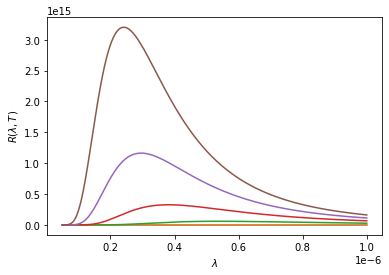

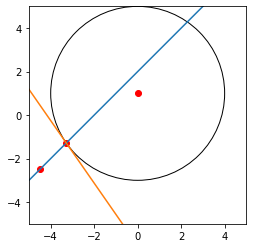

In [319]:
if __name__ == '__main__':
    trajectory = Trajectory(-4.5, (2, 1), (0, 1, 4))
    analyze()
    trajectory.draw()